# I. Connect to My Drive to Import Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
my tooken :) 
Mounted at /content/drive


# II. Install dependencies

In [ ]:
!pip install pytorch_lightning
!pip install pytorch_forecasting
!pip install torchmetrics==0.5.0

In [ ]:
!pip install -U pandas-profiling

# III. Import dependecies

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import copy
from pathlib import Path
import warnings

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# IV. Data Cleaning and Processing

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/0000000000aaaaaaaaaa/header.csv")

In [ ]:
df.isnull().sum()

Unnamed: 0                                 0
Year                                       0
DOY                                        0
PST                                        0
Global Horizontal [W/m^2]                  0
Direct Normal [W/m^2]                      0
Diffuse Horizontal [W/m^2]                 0
Air Temperature [deg C]                    0
Station Pressure [mBar]                    0
Avg Wind Speed @ 3m [m/s]                  0
Avg Wind Direction @ 3m [deg from N]       0
Avg Wind Direction (std dev) @ 3m [deg]    0
Avg Wind Speed (std dev) @ 3m [m/s]        0
Peak Wind Speed @ 3m [m/s]                 0
Global (uncorrected) [W/m^2]               0
Direct (uncorrected) [W/m^2]               0
Diffuse (uncorrected) [W/m^2]              0
Global (secondary) [W/m^2]                 0
Unnamed: 18                                0
Zenith Angle [degrees]                     0
Azimuth Angle [degrees]                    0
CR1000 Temp [deg C]                        0
RSR Batter

# V. Correletion measure 

In [ ]:
df.corr(method ='pearson')['Global (secondary) [W/m^2]']

Unnamed: 0                                      NaN
Year                                            NaN
DOY                                       -0.080950
PST                                       -0.121724
Global Horizontal [W/m^2]                  0.152663
Direct Normal [W/m^2]                      0.167731
Diffuse Horizontal [W/m^2]                 0.004402
Air Temperature [deg C]                    0.852530
Station Pressure [mBar]                         NaN
Avg Wind Speed @ 3m [m/s]                  0.144658
Avg Wind Direction @ 3m [deg from N]       0.144679
Avg Wind Direction (std dev) @ 3m [deg]    0.144704
Avg Wind Speed (std dev) @ 3m [m/s]        0.144656
Peak Wind Speed @ 3m [m/s]                 0.144659
Global (uncorrected) [W/m^2]               0.997991
Direct (uncorrected) [W/m^2]               0.928133
Diffuse (uncorrected) [W/m^2]              0.912097
Global (secondary) [W/m^2]                 1.000000
Unnamed: 18                                0.147072
Zenith Angle

## Conclusion

- The corelated columns with the output <b>Global (secondary) [W/m^2]</b> are : <br>
  1. Zenith Angle [degrees]
  2. CR1000 Temp [deg C]
  3. RSR Battery [VDC]
  4. Rel Humidity [%]
  5. Global (uncorrected) [W/m^2]
  6. Direct (uncorrected) [W/m^2]
  7. Diffuse (uncorrected) [W/m^2]

# VI. Preaparing Temporal Fusion Transformers 

In [ ]:
data = df.copy()
data["time_idx"] = data.index

In [ ]:
max_encoder_length = 36
max_prediction_length = 1


training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <=3793*0.75 ],  # 75% for traning
    time_idx= "time_idx",  # column name of time of observation
    target= "Global (secondary) [W/m^2]",  # column name of target to predict
    group_ids=["DOY"],  # column name(s) for timeseries IDs
    max_encoder_length=max_encoder_length,  # how much history to use
    max_prediction_length=max_prediction_length,  # how far to predict into future
    allow_missing_timesteps=True,
    time_varying_known_reals=["time_idx", 
                              "DOY",
                              'Zenith Angle [degrees]',
                              'CR1000 Temp [deg C]',
                              'RSR Battery [VDC]',
                              'Rel Humidity [%]',
                              'Global (uncorrected) [W/m^2]',
                              'Direct (uncorrected) [W/m^2]',
                              'Diffuse (uncorrected) [W/m^2]'
                              ],
    time_varying_unknown_reals=["Global (secondary) [W/m^2]"]
)

# create validation dataset using the same normalization techniques as for the training dataset
validation = TimeSeriesDataSet.from_dataset(training, data, min_prediction_idx=training.index.time.max() + 1, stop_randomization=True)

# convert datasets to dataloaders for training
batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=2)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=2)

In [ ]:
# create PyTorch Lighning Trainer with early stopping
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=1, verbose=False, mode="min")
lr_logger = LearningRateMonitor()

trainer = pl.Trainer(
    max_epochs=100,
    weights_summary="top",
    # gpus=1,  # run on CPU, if on multiple GPUs, use accelerator="ddp"
    gradient_clip_val=0.1,
    limit_train_batches=30,  # 30 batches per epoch
    callbacks=[lr_logger, early_stop_callback],
    logger=TensorBoardLogger("lightning_logs")
)

# define network to train - the architecture is mostly inferred from the dataset, so that only a few hyperparameters have to be set by the user
tft = TemporalFusionTransformer.from_dataset(
    # dataset
    training,
    # architecture hyperparameters
    hidden_size=32,
    attention_head_size=1,
    dropout=0.8,
    hidden_continuous_size=16,
    # loss metric to optimize
    loss=QuantileLoss(),
    # logging frequency
    log_interval=2,
    # optimizer parameters
    learning_rate=0.03,
    reduce_on_plateau_patience=10
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Number of parameters in network: 93.2k


## Training The model

In [ ]:
# fit the model on the data - redefine the model with the correct learning rate if necessary
trainer.fit(
    tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader,
)


   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 320   
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 20.6 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 18.3 K
7  | static_context_variable_selection  | GatedResidualNetwork            | 4.3 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 4.3 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 4.3 

Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:327: UserWarning:

The number of training samples (21) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.



Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [ ]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)


In [ ]:
# calcualte mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)

# VII. Error Measure

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


MAE = mean_absolute_error(actuals, predictions)
print("MAE = ", MAE)
MSE = mean_squared_error(actuals, predictions)
print("MSE = ", MSE)
R2_Score = r2_score(actuals, predictions, multioutput='variance_weighted')
print("R2_Score = {}%".format(round(R2_Score*100,2)))

MAE =  2.3976204
MSE =  13.226589
R2_Score = 93.59%


# VII. Plotting Results

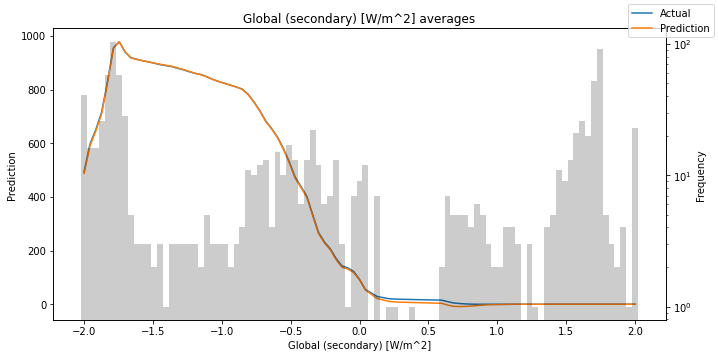

In [ ]:
predictions, x = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(x, predictions)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals,'Global (secondary) [W/m^2]');

Ahbar abdellah made with heart ❤ <br>
LinkedIn :  https://www.linkedin.com/in/abdellah-ahbar-9624b5197/ <br>
Mail : ahbarabdellah12@gmail.com 
